In [ ]:
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 749, done.
remote: Total 749 (delta 0), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (749/749), 114.90 MiB | 33.34 MiB/s, done.
Resolving deltas: 100% (344/344), done.
Checking out files: 100% (129/129), done.
Processing ./deepul
  Created wheel for deepul: filename=deepul-0.1.0-cp36-none-any.whl size=16679 sha256=b7eb114ce5d563fb972abc756272f5da301f0ea02656941803bf60a329dcd06f
  Stored in directory: /tmp/pip-ephem-wheel-cache-3uw_07_r/wheels/39/1a/4b/a6f51db275abb2e5dae32540e06ed5011e792f162467bd3aa8
Successfully built deepul
  Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [ ]:
from deepul.hw1_helper import *

In [ ]:
class MaskedCon2d(nn.Conv2d):
  def __init__(self, color_conditioning, mask_type, conditional_size, **kwargs):
    super().__init__(**kwargs)
    self.color_conditioning = color_conditioning
    self.register_buffer('mask', torch.zeros_like(self.weight))
    self.create_mask(mask_type)

    self.conditional_size = conditional_size
    self.condition_transformation = nn.Linear(conditional_size[0], self.out_channels)
  
  def forward(self, x, condition):
    batch_size = x.shape[0]
    out = F.conv2d(x, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
    #print(out.shape)
    temp = self.condition_transformation(condition)
    #print(temp.shape)
    return out + temp.view(batch_size, -1, 1, 1)

  def create_mask(self, mask_type):
    k = self.kernel_size[0]
    # C_out, C_in/groups, H, W
    self.mask[:, :, :k // 2] = 1 # all rows in the upper half
    self.mask[:, :, k // 2, :k // 2] = 1 # all elements in the left half of the center row

    if self.color_conditioning:
      assert self.in_channels % 3 ==0 and self.out_channels % 3 == 0
      c_in_each_color = self.in_channels // 3
      c_out_each_color = self.out_channels // 3
      if mask_type == 'B':
        self.mask[:c_out_each_color, :c_in_each_color, k//2, k//2 ] = 1
        self.mask[c_out_each_color:(2*c_out_each_color), :(2 * c_in_each_color), k//2, k//2 ] = 1
        self.mask[(2*c_out_each_color):, :, k//2, k//2 ] = 1
      
      else:
        self.mask[c_out_each_color:(2*c_out_each_color), :c_in_each_color, k//2, k//2] = 1
        self.mask[(2*c_out_each_color):, :(2 * c_in_each_color), k//2, k//2] = 1
    
    else:
      if mask_type == 'B':
        # add the center
        self.mask[:, :, k // 2, k // 2] = 1

class ResidualBlock(nn.Module):
  def __init__(self, color_conditioning, conditional_size, in_channels=128):
    super().__init__()
    self.net = nn.ModuleList([nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning, conditional_size=conditional_size,
                                         in_channels=in_channels, out_channels=in_channels // 2, kernel_size=1),
                              nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning, conditional_size=conditional_size,
                                         in_channels=in_channels // 2, out_channels=in_channels // 2, kernel_size=9, padding=4),
                              nn.ReLU(),
                              MaskedCon2d(mask_type='B', color_conditioning=color_conditioning, conditional_size=conditional_size,
                                         in_channels=in_channels // 2, out_channels=in_channels, kernel_size=1)
        ])
    # self.conditional_size = conditional_size
    # self.condition_transformation = nn.Linear(conditional_size, self.out_channels)

  def forward(self, x, condition):
    out = x
    for l in self.net:
      if isinstance(l, MaskedCon2d):
        out = l(out, condition)
      else:
        out = l(out)
    return out + x


class PixelCNN_V2(nn.Module):

  def __init__(self, input_shape, d, conditional_size, n_filters=128,
               color_conditioning=False):
    super().__init__()
    n_channels = input_shape[0]
    self.net = nn.ModuleList([MaskedCon2d(mask_type='A', color_conditioning=color_conditioning, conditional_size=conditional_size,
                                          in_channels=n_channels, out_channels=n_filters, kernel_size=7, padding=7//2)])
    for _ in range(2):
      self.net.extend([ResidualBlock(color_conditioning, conditional_size=conditional_size, in_channels=n_filters)])

    self.net.extend([nn.ReLU(),
                  MaskedCon2d(mask_type='B', color_conditioning=color_conditioning, conditional_size=conditional_size,
                                          in_channels=n_filters, out_channels=d * n_channels, kernel_size=1)])
  
    self.input_shape = input_shape
    self.d = d
    self.n_channels = n_channels
    self.color_conditioning = color_conditioning


  def forward(self, x, condition):
    batch_size = x.shape[0]
    out = x.float() 
    for layer in self.net:
      if isinstance(layer, MaskedCon2d) or isinstance(layer, ResidualBlock):
        out = layer(out, condition)
      else:
        out = layer(out)
    return out.view(batch_size, self.d, *self.input_shape)

  def loss(self, x, condition):
    return F.cross_entropy(self(x, condition), x.long())

  def sample(self, n, condition):
    samples = torch.zeros(n, *self.input_shape).cuda()
    with torch.no_grad():
      for r in range(self.input_shape[1]):
        for c in range(self.input_shape[2]):
          for k in range(self.n_channels):
            logits = self(samples, condition)[:, :, k, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples.permute(0, 2, 3, 1).cpu().numpy()



In [ ]:
def train(model, train_loader, test_loader, param):
  n_epochs = param['epochs']
  lr = param['lr']
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  t = []
  e = [eval_loss(model, test_loader, optimizer)]
  for i in range(n_epochs):
    train_loss_ = train_loss(model, train_loader, optimizer)
    t.extend(train_loss_)
    eval_loss_ = eval_loss(model, test_loader, optimizer)
    e.append(eval_loss_)
  return t, e

In [ ]:

def train_loss(model, train_loader, optimizer):
  model.train()
  loss = []
  for x, y in train_loader:
    y = y.cuda().float()
    x = x.cuda().contiguous()
    l = model.loss(x, y)
    loss.append(l.item())
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
  return loss


def eval_loss(model, test_loader, optimizer):
  model.eval()
  loss = 0
  for x, y in test_loader:
    y = y.cuda().float()
    x = x.cuda().contiguous()
    l = model.loss(x, y)
    loss += l * x.shape[0]

  return (loss/len(test_loader.dataset)).item()

In [ ]:
class XYDataset(data.Dataset):
  def __init__(self, x, y):
    super().__init__()
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    return self.x[index], self.y[index]

In [ ]:
def q3_d(train_data, train_labels, test_data, test_labels, image_shape, n_classes, dset_id):
  """
  train_data: A (n_train, H, W, 1) numpy array of binary images with values in {0, 1}
  train_labels: A (n_train,) numpy array of class labels
  test_data: A (n_test, H, W, 1) numpy array of binary images with values in {0, 1}
  test_labels: A (n_test,) numpy array of class labels
  image_shape: (H, W), height and width
  n_classes: number of classes (4 or 10)
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, C, 1) of samples with values in {0, 1}
    where an even number of images of each class are sampled with 100 total
  """
  
  """ YOUR CODE HERE """
  def preprocess(data, labels, n_classes):
    data = np.transpose(data, (0, 3, 1, 2))
    labels_oh = np.zeros((len(labels), n_classes))
    labels_oh[np.arange(len(labels)), labels] = 1
    return data, labels_oh.astype(float)

  train_x, train_y = preprocess(train_data, train_labels, n_classes)
  test_x, test_y = preprocess(test_data, test_labels, n_classes)

  H, W = image_shape
  model = PixelCNN_V2((1, H, W), 2, (n_classes,), n_filters=32).cuda()
  train_loader = data.DataLoader(XYDataset(train_x, train_y), batch_size=128, shuffle=True)
  test_loader = data.DataLoader(XYDataset(test_x, test_y), batch_size=128)
  train_losses, test_losses = train(model, train_loader, test_loader, 
                                           dict(epochs=10, lr=1e-3))
  
  to_sample_label = np.zeros((100, n_classes))
  for i in range(n_classes):
    to_sample_label[ (i) * (100//n_classes) : (i + 1) * (100//n_classes),i] = 1
  
  label_tensor = torch.FloatTensor(to_sample_label).cuda()
  print(label_tensor)
  sample = model.sample(100, label_tensor)
  return train_losses, test_losses, sample

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

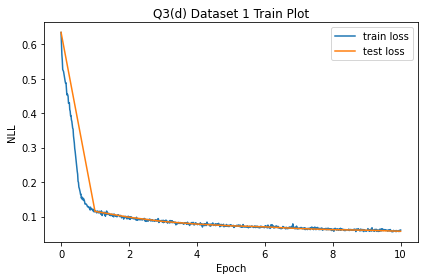

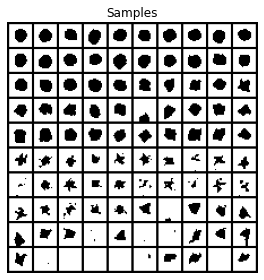

In [ ]:
q3d_save_results(1, q3_d)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],


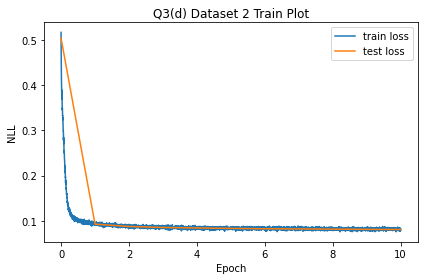

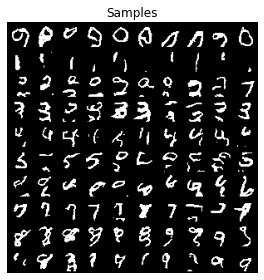

In [ ]:
q3d_save_results(2, q3_d)